## Loading libraries

In [1]:
#  short workbook to convert currency string into float number value
import pandas as pd
import numpy as np

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'
from statsmodels.tsa.seasonal import seasonal_decompose

## Loading data

In [2]:
df = pd.read_csv('ma_lga_12345.csv', index_col = 0, parse_dates = True)

In [4]:
df = df[2:]

In [4]:
# 1st : visualise different scenarios

## EDA

In [5]:
list_type = set(df.type)
print(f"Possible housing types {list_type}")

list_bed = set(df.bedrooms)
len(list_bed)
print(f"Possible nb of bedrooms {list_bed}")

combined = [(f,s) for f in list_type for s in list_bed]


Possible housing types {'unit', 'house'}
Possible nb of bedrooms {1, 2, 3, 4, 5}


#### Median quarterly prices by type and number of bedrooms

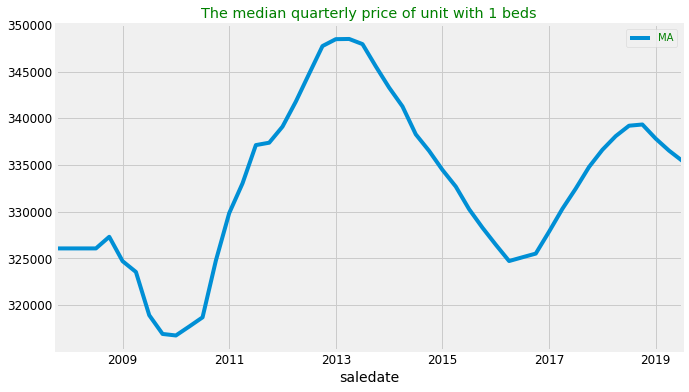

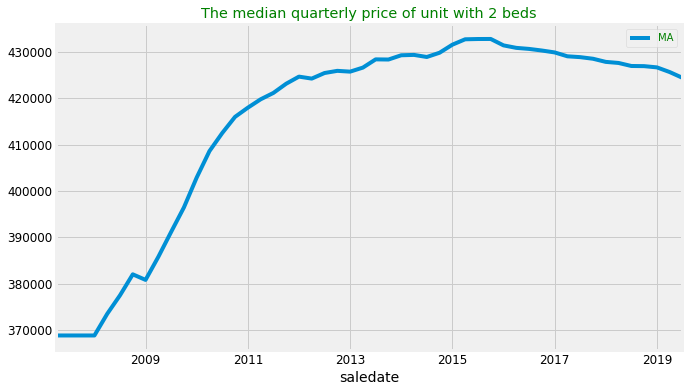

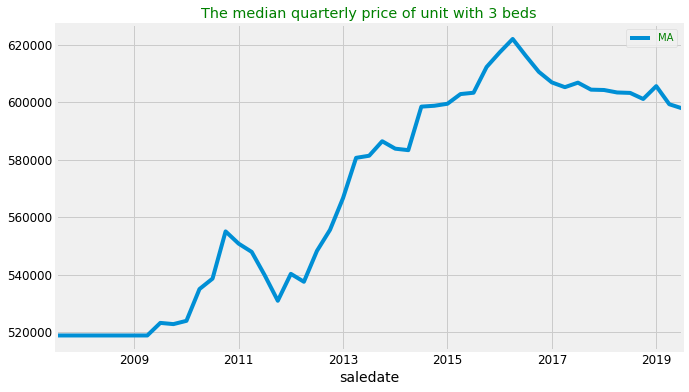

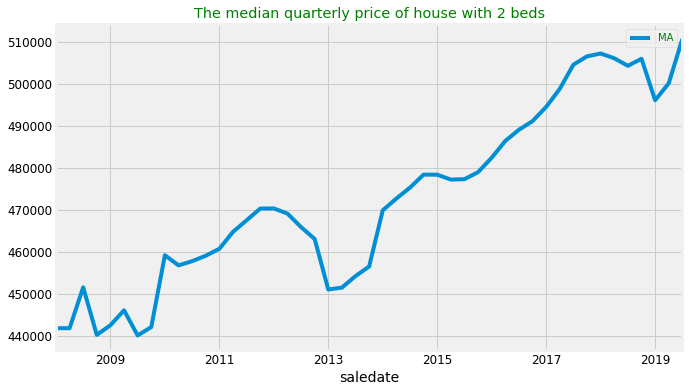

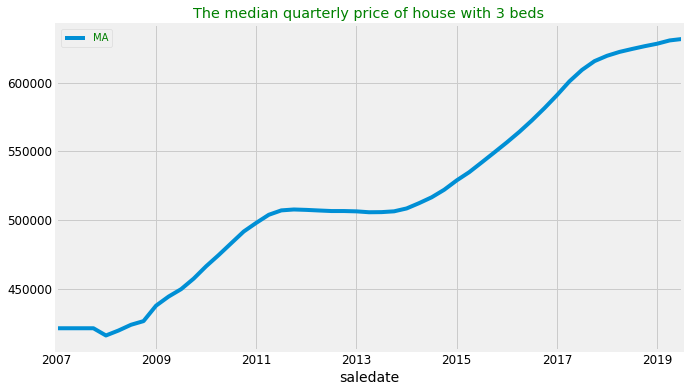

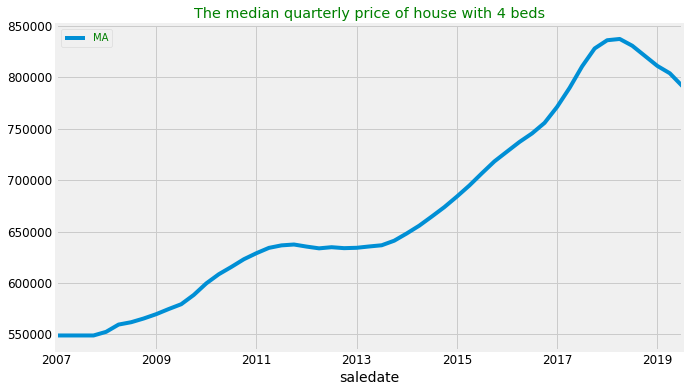

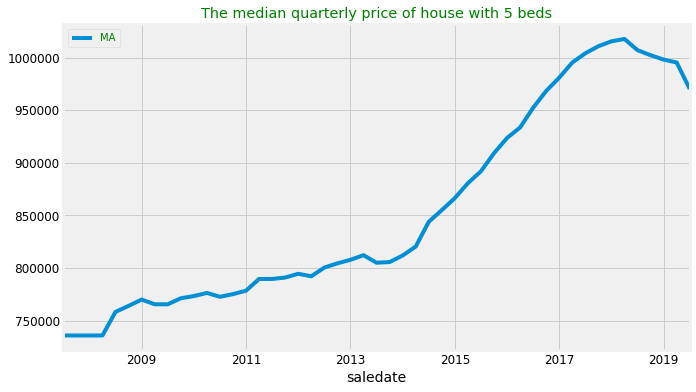

In [6]:
for i, j in combined:
    current_df = df[(df['type'] == i) & (df['bedrooms'] == j)]
    current_df = current_df.drop(['type', 'bedrooms'], axis = 1)
#     print(current_df)
    if current_df.empty:
        pass
    else:
        current_df.plot(figsize= (10,6), title = ('The median quarterly price of ' + i + ' with ' + str(j) + ' beds' ))
#     plot.show()

The line graphs show that the prices of big houses and units went down over the past few years and went up for the 2 and 3 bed house

#### Seasonal decomposition

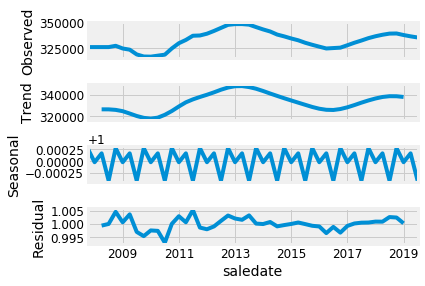

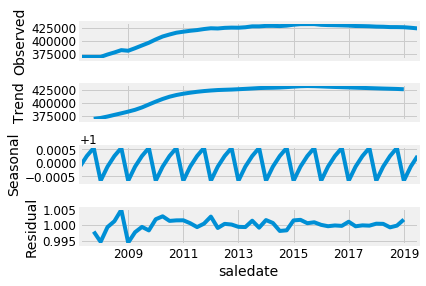

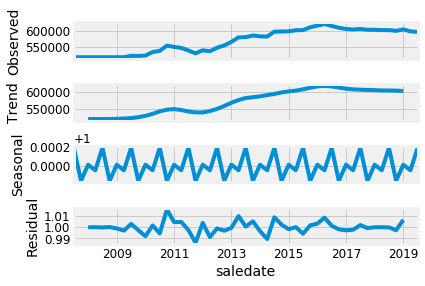

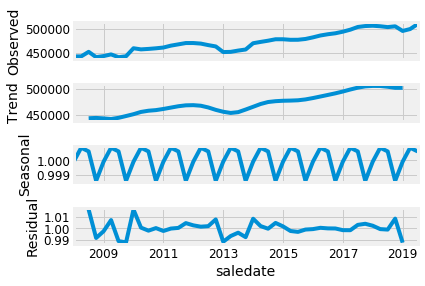

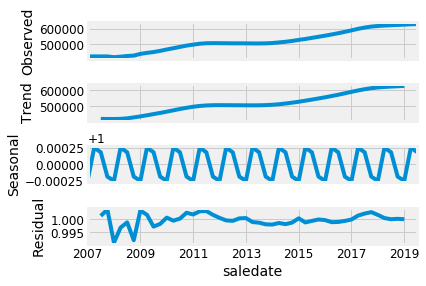

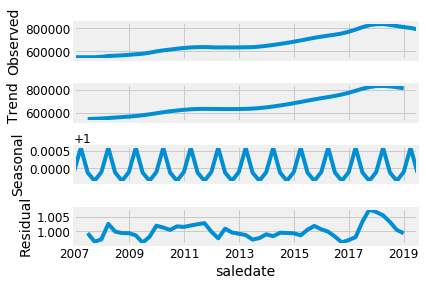

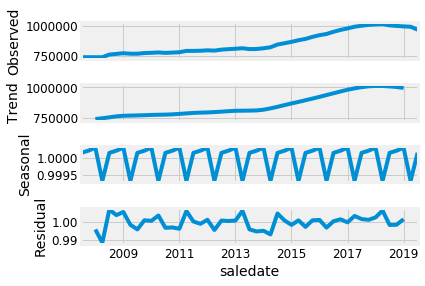

In [7]:
for i, j in combined:
    current_df = df[(df['type'] == i) & (df['bedrooms'] == j)]
    current_df = current_df.drop(['type', 'bedrooms'], axis = 1)
#     print(current_df)
    if current_df.empty:
        pass
    else:
        decomposition = seasonal_decompose(current_df['MA'], model='multiplicative')
        fig = decomposition.plot()
        plt.show()


The decomposition shows the strong seasonality for all types of housing and changing trends

## Checking for stationarity 

Stationary data can be used for modelling, non-stationarity will require and I component of the ARIMA or SARIMAX models

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [9]:
for i, j in combined:
    current_df = df[(df['type'] == i) & (df['bedrooms'] == j)]
    current_df = current_df.drop(['type', 'bedrooms'], axis = 1)
#     print(current_df)
    if current_df.empty:
        pass
    else:
        print(adf_test(current_df['MA']))

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.093957
p-value                  0.027004
# lags used              6.000000
# observations          41.000000
critical value (1%)     -3.600983
critical value (5%)     -2.935135
critical value (10%)    -2.605963
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None
Augmented Dickey-Fuller Test: 
ADF test statistic      -3.236814
p-value                  0.017950
# lags used              1.000000
# observations          48.000000
critical value (1%)     -3.574589
critical value (5%)     -2.923954
critical value (10%)    -2.600039
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None
Augmented Dickey-Fuller Test: 
ADF test statistic      -1.570756
p-value                  0.498265
# lags used              5.000000
# observations          43.000000
critical value (1%)     -3.592504
critical value (5%)     -2.93

## Checking for Auto-correlation and Partial auto-correlation of time-series data

In [10]:
# autocorrelation and partial autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

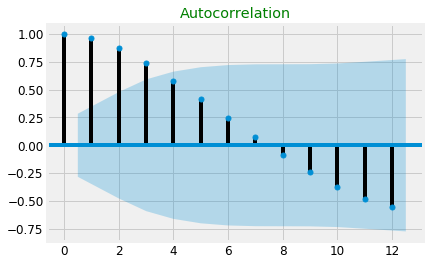

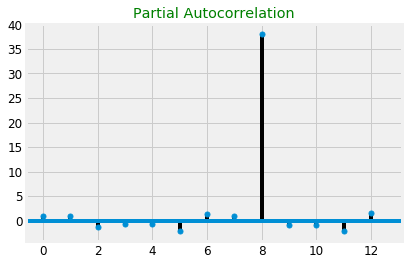

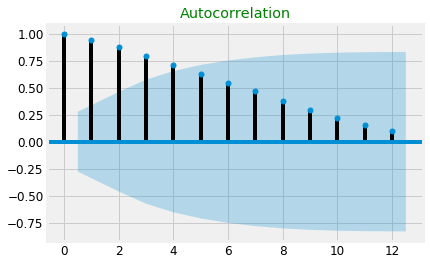

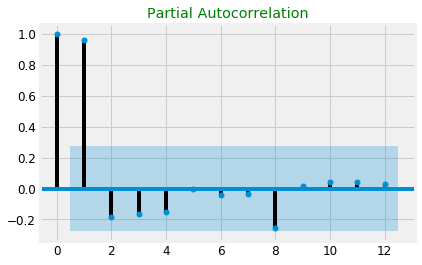

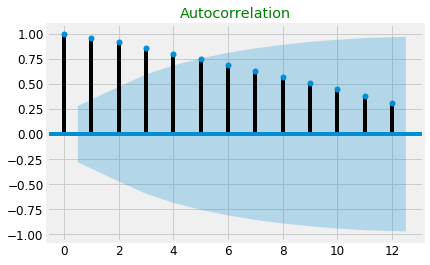

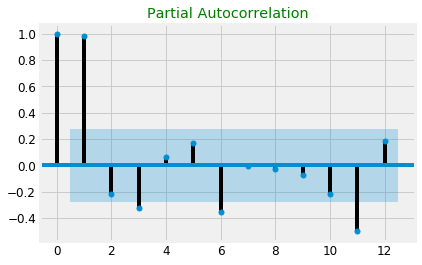

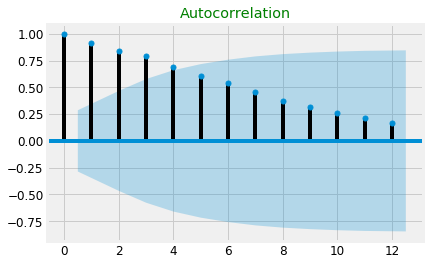

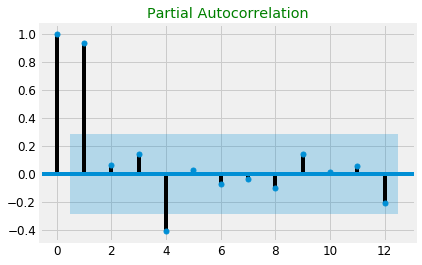

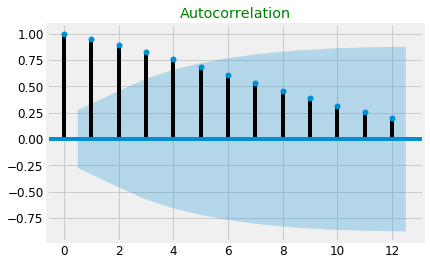

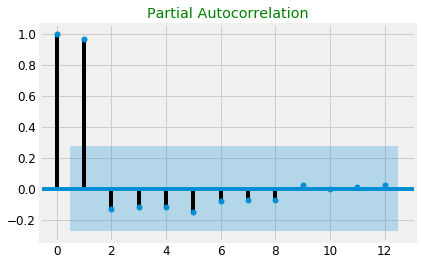

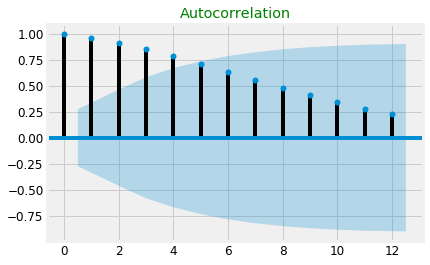

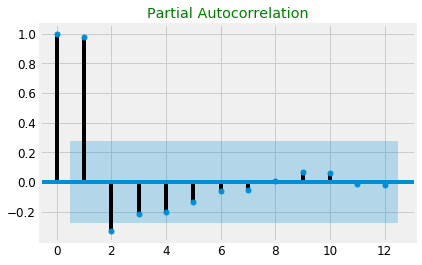

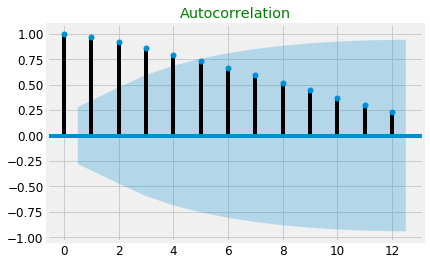

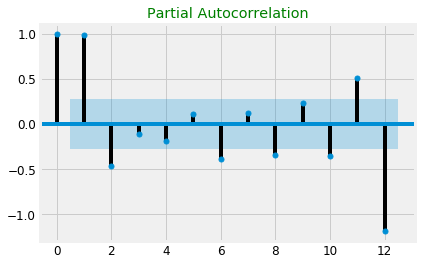

In [11]:
for i, j in combined:
    current_df = df[(df['type'] == i) & (df['bedrooms'] == j)]
    current_df = current_df.drop(['type', 'bedrooms'], axis = 1)
#     print(current_df)
    if current_df.empty:
        pass
    else:
        plot_acf(current_df, lags = 12); 
        plot_pacf(current_df, lags = 12); 
        
# how to read those charts:
# if autocorrelation plots shows the positive autocorrelation with n-lag it suggests to use AR model with n-lags
# if autocorrelation plots shows the negative autocorrelation then it suggests using MA model

## Modelling time-series data

using auto-arima library for finding the best order and seasonal parameters

In [12]:
from pmdarima import auto_arima

C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


By the look on the decompostion charts, although there is some seasonality, its scale is much lower than the changes in trend and therefore the seasonality will not be taken into account for creating the time series model

#### Models for all combinations of properties

In [13]:
for i, j in combined:
    current_df = df[(df['type'] == i) & (df['bedrooms'] == j)]
    current_df = current_df.drop(['type', 'bedrooms'], axis = 1)
#     print(current_df)
    if current_df.empty:
        pass
    else:
        stepwise_fit = auto_arima(current_df['MA'], start_p = 0, start_q= 0, max_p = 6, max_q = 3,seasonal = False).summary()
        print(stepwise_fit)
#         stepwise_fit.plot()

C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   48
Model:                     ARMA(2, 2)   Log Likelihood                -413.850
Method:                       css-mle   S.D. of innovations           1274.384
Date:                Mon, 15 Jun 2020   AIC                            839.699
Time:                        23:56:47   BIC                            850.926
Sample:                             0   HQIC                           843.942
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.324e+05   2996.849    110.924      0.000    3.27e+05    3.38e+05
ar.L1.y        1.6719      0.128     13.069      0.000       1.421       1.923
ar.L2.y       -0.7441      0.124     -5.982      0.0

C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   48
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -493.657
Method:                       css-mle   S.D. of innovations           7033.868
Date:                Mon, 15 Jun 2020   AIC                            995.315
Time:                        23:56:52   BIC                           1002.800
Sample:                             1   HQIC                           998.143
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2891.9880   3803.946      0.760      0.451   -4563.610    1.03e+04
ar.L1.D.y      0.4486      0.156      2.874      0.006       0.143       0.755
ar.L2.D.y      0.2888      0.157      1.835      0.0

#### Checking the auto_arima results on the example of House with 2 beds

1. adf test says it is not non-stationary
2. auto-arima suggest differencing by one - try if that will make data stationary

In [14]:
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.tools import diff

In [15]:
# resenting index for calc differencing
df_h2 = df.reset_index()
df_h2 = df_h2[(df_h2.type == 'house') & (df_h2.bedrooms == 2)]

# differencing
df_h2['Diff'] = diff(df_h2['MA'], k_diff = 1)

# reseting index to datetime
df_h2 = df_h2.set_index('saledate')

df_h2[:4]

,MA,type,bedrooms,Diff
saledate,,,,
2008-03-31,441854,house,2,NaN
2008-06-30,441854,house,2,0.0
2008-09-30,451583,house,2,9729.0
2008-12-31,440256,house,2,-11327.0


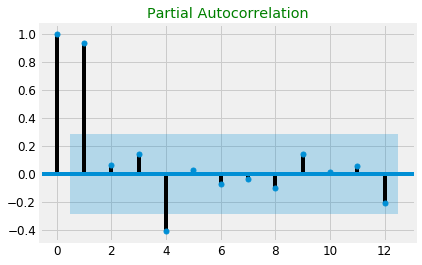

In [16]:
plot_pacf(df_h2['MA'], lags = 12); 

# rule if pacf has a sharp cut off then consider using A. the lag is AR parameter
# here lag of 1

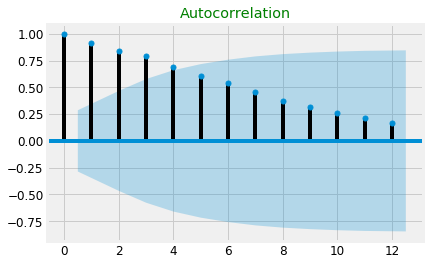

In [18]:
plot_acf(df_h2['MA'], lags = 12); 

# if the acf decreases more slowly (has significant values at higher lags) and pacf has a sharp drop it implies MA should not be used

In [29]:
# suggested by plots and differencing
# AR = 1
# I = 1
# MA = 0 or 1

stepwise_fit = auto_arima(df_h2['MA'], start_p = 1, start_q= 0, max_p = 2, max_q = 2,seasonal = False, trace = True).summary()

Fit ARIMA: order=(1, 1, 0); AIC=923.418, BIC=928.904, Fit time=0.033 seconds
Fit ARIMA: order=(0, 1, 0); AIC=921.430, BIC=925.088, Fit time=0.002 seconds
Fit ARIMA: order=(0, 1, 1); AIC=923.416, BIC=928.902, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.054 seconds


#### 

In [30]:
stepwise_fit

# the best result is ARIMA (0,1,0) although not suggested by the acf and pacf plots

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   46
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -458.715
Method:                           css   S.D. of innovations           5182.949
Date:                Mon, 15 Jun 2020   AIC                            921.430
Time:                        23:59:26   BIC                            925.088
Sample:                             1   HQIC                           922.800
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1496.9130    764.184      1.959      0.056      -0.860    2994.686
==============================================================================
"""

## Model

In [ ]:
# house 2 bed

In [31]:
print(len(df_h2))
df_h2.tail()

47


,MA,type,bedrooms,Diff
saledate,,,,
2018-09-30,504318,house,2,-1798.0
2018-12-31,506001,house,2,1683.0
2019-03-31,496133,house,2,-9868.0
2019-06-30,500158,house,2,4025.0
2019-09-30,510712,house,2,10554.0


In [21]:
train = df_h2[:44]
test = df_h2[44:]

In [32]:
model = ARIMA(df_h2['MA'].astype('float64'), order = (0,1,0))
results = model.fit()
results.summary()

C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D.MA   No. Observations:                   46
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -458.715
Method:                           css   S.D. of innovations           5182.949
Date:                Mon, 15 Jun 2020   AIC                            921.430
Time:                        23:59:42   BIC                            925.088
Sample:                    06-30-2008   HQIC                           922.800
                         - 09-30-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1496.9130    764.184      1.959      0.056      -0.860    2994.686
==============================================================================
"""

In [33]:
start = len(train)
end = len(train) + len(test) -1

predictions = results.predict(start = start, end = end, typ = 'levels').rename('Predictions_ARIMA')

In [34]:
predictions

2019-03-31    507497.913043
2019-06-30    497629.913043
2019-09-30    501654.913043
Freq: Q-DEC, Name: Predictions_ARIMA, dtype: float64

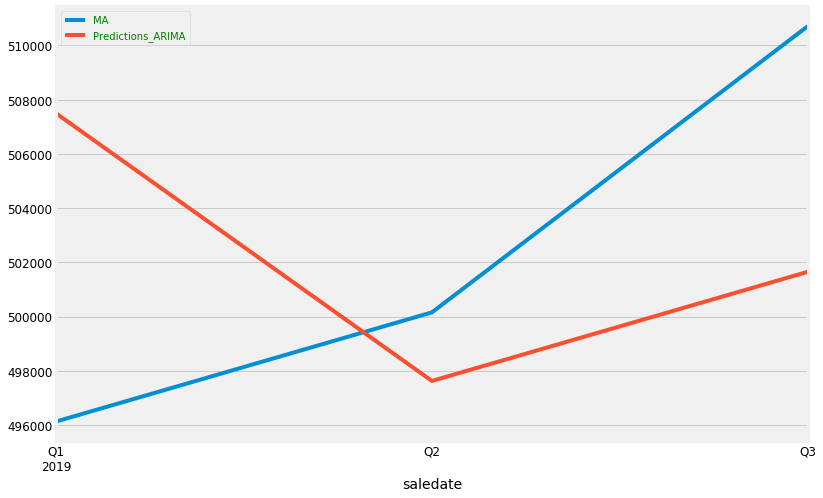

In [35]:
test['MA'].plot(figsize = (12,8), legend = True)
predictions.plot(legend=True)

In [36]:
# check the error 

from statsmodels.tools.eval_measures import rmse

error = rmse(test['MA'], predictions)
print(f"Error value: {error}")
print(f"Mean predictions value {predictions.mean()}")

Error value: 8516.323468953684
Mean predictions value 502260.9130434783


In [27]:
# what is the scale of the error
mean_test = test.MA.mean()

print(f"The avg value of the test set: {mean_test}")

The avg value of the test set: 502334.3333333333


## Forecast

### Forcasting with Arima

In [37]:
model = ARIMA(df_h2['MA'].astype('float64'), order = (0,1,0))
results = model.fit()
fcast = results.predict(start = len(df_h2['MA']), end = len(df_h2['MA'])+4, typ = 'levels').rename('Forecast Arima')

C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


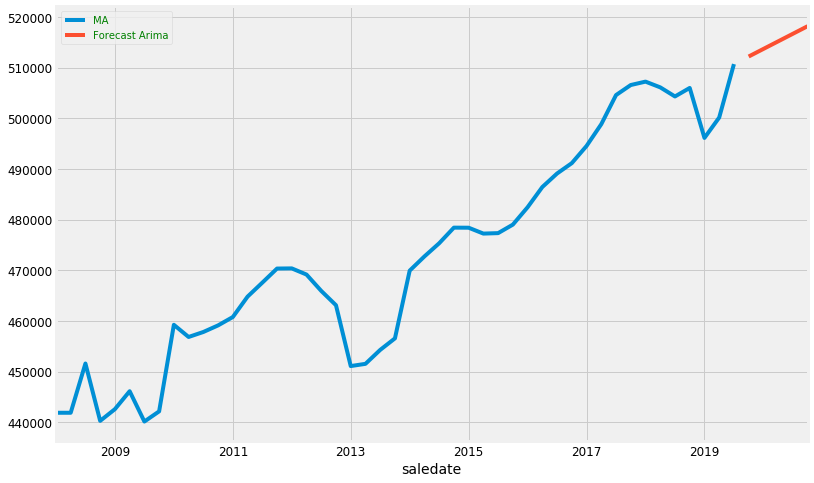

In [38]:
df_h2['MA'].plot(figsize = (12,8), legend = True)
fcast.plot(legend = True)

### Forcasting with Sarimax: Seasonal Variety of ARIMA

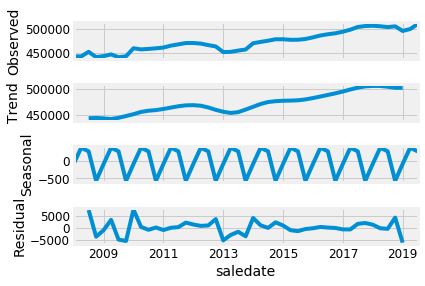

In [39]:
result = seasonal_decompose(df_h2['MA'])
result.plot();

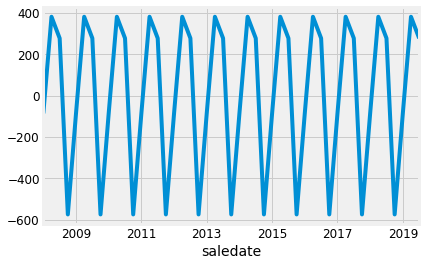

In [40]:
result.seasonal.plot()

In [41]:
# seasonal option

stepwise_fit = auto_arima(df_h2['MA'], start_p = 1, start_q= 0, max_p = 2, max_q = 2,seasonal = True, trace = True, m = 4).summary()

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 1, 4); AIC=920.132, BIC=929.275, Fit time=0.150 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 4); AIC=921.430, BIC=925.088, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 4); AIC=925.351, BIC=932.666, Fit time=0.048 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 4); AIC=925.773, BIC=933.088, Fit time=0.063 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 1, 4); AIC=925.351, BIC=932.666, Fit time=0.041 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 4); AIC=920.561, BIC=931.533, Fit time=0.134 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 2, 4); AIC=920.494, BIC=931.465, Fit time=0.083 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 4); AIC=923.352, BIC=928.837, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 2, 4); AIC=922.542, BIC=935.343, Fit time=0.195 seconds


C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 4); AIC=916.985, BIC=924.299, Fit time=0.179 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 4); AIC=919.366, BIC=928.509, Fit time=0.202 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 4); AIC=919.977, BIC=930.949, Fit time=0.191 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 4); AIC=923.430, BIC=928.916, Fit time=0.042 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 4); AIC=918.398, BIC=927.541, Fit time=0.166 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 4); AIC=923.430, BIC=928.916, Fit time=0.045 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 2, 4); AIC=918.326, BIC=927.469, Fit time=0.078 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 2, 4); AIC=916.780, BIC=927.752, Fit time=0.230 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 2, 4); AIC=921.462, BIC=934.262, Fit time=0.129 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 4);

C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 2, 4); AIC=908.365, BIC=926.651, Fit time=0.523 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 4); AIC=910.410, BIC=926.868, Fit time=0.500 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 4); AIC=910.684, BIC=927.142, Fit time=0.371 seconds


C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 4); AIC=910.994, BIC=925.623, Fit time=0.299 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 0, 2, 4); AIC=912.458, BIC=928.915, Fit time=0.558 seconds
Total fit time: 6.137 seconds


In [42]:
stepwise_fit

# the best result is ARIMA (0,1,0) x (2,0,0,4) although not suggested by the acf and pacf plots

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   47
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 4)   Log Likelihood                -444.182
Date:                           Tue, 16 Jun 2020   AIC                            908.365
Time:                                   00:00:51   BIC                            926.651
Sample:                                        0   HQIC                           915.215
                                            - 47                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1690.4943   3161.372      0.535      0.593   -4505.680    7886.669
ar.L1         -0.8001      0.309     -2.587      0.010      -1.406      -0.194
ar.L2         -0.6215      0.262     -2.369      0.018      -1.136      -0.107
ma.L1          0.8039      0.301      2.673      0.008       0.214       1.393
ma.L2          0.6518      0.254      2.569      0.010       0.155       1.149
ar.S.L4       -0.3779      0.377     -1.003      0.316      -1.116       0.360
ar.S.L8        0.5282      0.340      1.551      0.121      -0.139       1.196
ma.S.L4        0.3835      0.397      0.967      0.334      -0.394       1.161
ma.S.L8       -0.5022      0.353     -1.421      0.155      -1.195       0.190
sigma2      1.851e+07      0.778   2.38e+07      0.000    1.85e+07    1.85e+07
===================================================================================
Ljung-Box (Q):                       60.39   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.02   Prob(JB):                         0.80
Heteroskedasticity (H):               3.49   Skew:                            -0.06
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.77e+23. Standard errors may be unstable.
"""

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

model = SARIMAX(df_h2['MA'].astype('float64'), order = (2,1,2), seasonal_order = (2, 0, 2, 4))
results = model.fit()
results.summary()

C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                MA   No. Observations:                   47
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 4)   Log Likelihood                -445.616
Date:                           Tue, 16 Jun 2020   AIC                            909.232
Time:                                   00:01:26   BIC                            925.690
Sample:                               03-31-2008   HQIC                           915.397
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8474      0.505     -1.678      0.093      -1.837       0.142
ar.L2         -0.5729      0.445     -1.287      0.198      -1.446       0.300
ma.L1          0.8519      0.496      1.717      0.086      -0.120       1.824
ma.L2          0.6036      0.431      1.400      0.162      -0.242       1.449
ar.S.L4       -0.1809      0.254     -0.713      0.476      -0.678       0.316
ar.S.L8        0.6524      0.251      2.601      0.009       0.161       1.144
ma.S.L4        0.1817      0.275      0.661      0.509      -0.357       0.721
ma.S.L8       -0.6241      0.264     -2.361      0.018      -1.142      -0.106
sigma2      1.915e+07   4.45e-08   4.31e+14      0.000    1.91e+07    1.91e+07
===================================================================================
Ljung-Box (Q):                       56.70   Jarque-Bera (JB):                 4.01
Prob(Q):                              0.04   Prob(JB):                         0.13
Heteroskedasticity (H):               4.41   Skew:                            -0.44
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.38e+31. Standard errors may be unstable.
"""

In [44]:
predictions_s = results.predict(start = start, end = end, typ = 'levels').rename('Predictions_SARIMAX')
predictions_s

2019-03-31    503655.936805
2019-06-30    496223.802275
2019-09-30    500163.072390
Freq: Q-DEC, Name: Predictions_SARIMAX, dtype: float64

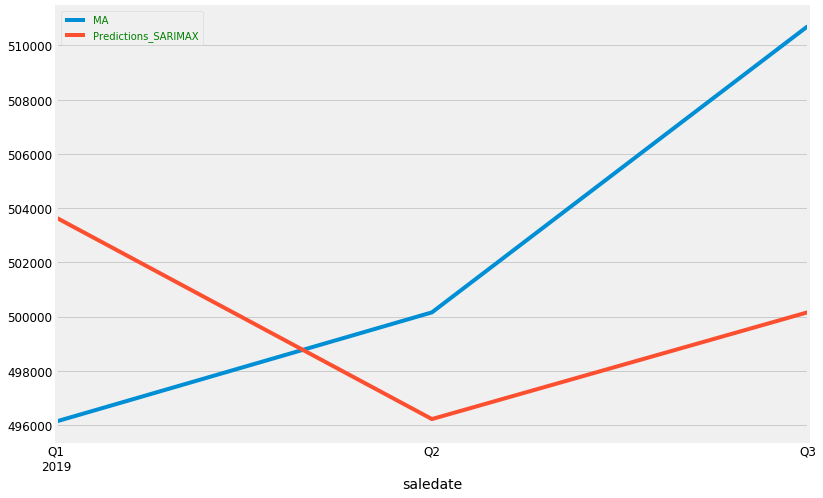

In [45]:
test['MA'].plot(figsize = (12,8), legend = True)
predictions_s.plot(legend=True)

In [46]:
# check the error 
#  non-seasonal model error is smaller 7377.0619886964105 

error = rmse(test['MA'], predictions_s)
print(f"Error value: {error}")
print(f"Mean predictions value {predictions_s.mean()}")

Error value: 7817.765316681277
Mean predictions value 500014.27048995066


In [49]:
model = SARIMAX(df_h2['MA'].astype('float64'), order = (2,1,2), seasonal_order= (2, 0, 2, 4))
results = model.fit()
fcast = results.predict(start = len(df_h2['MA']), end = len(df_h2['MA'])+4, typ = 'levels').rename('Forecast Sarimax')

C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


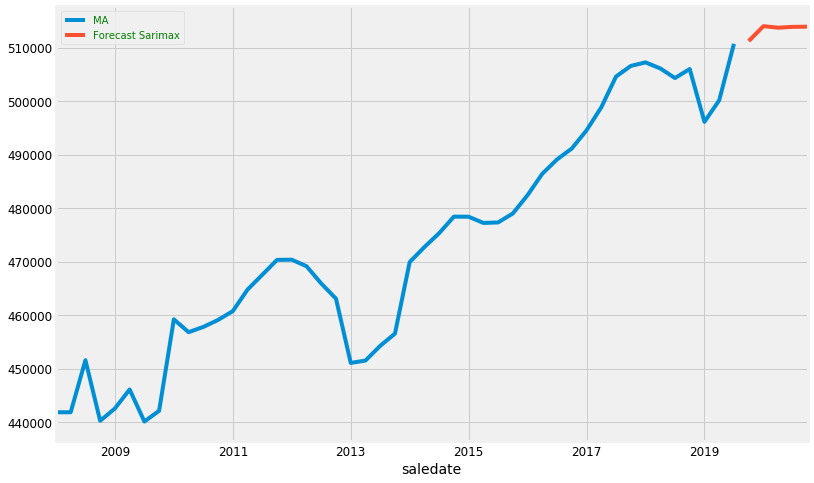

In [50]:
df_h2['MA'].plot(figsize = (12,8), legend = True)
fcast.plot(legend = True)